In [2]:
from pennylane import numpy as np

symbols = ["H", "H", "H"]
x = np.array([0.028, 0.054, 0.0, 0.986, 1.610, 0.0, 1.855, 0.002, 0.0], requires_grad=True)

https://pennylane.ai/qml/demos/tutorial_mol_geo_opt/

import pennylane as qml
def H(x):
    return qml.qchem.molecular_hamiltonian(symbols, x, charge=1)[0] ## original

In [12]:
import pennylane as qml
import pickle
with open("C:/Users/lclai/Desktop/quantum/hamiltonian.pkl", "rb") as f:
    H = pickle.load(f)
def H(x):
    return H

In [13]:
hf = qml.qchem.hf_state(electrons=2, orbitals=6)
print(hf)

[1 1 0 0 0 0]


In [14]:
num_wires = 6
dev = qml.device("lightning.qubit", wires=num_wires)


@qml.qnode(dev, interface="autograd")
def circuit(params, obs, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(params[0], wires=[0, 1, 2, 3])
    qml.DoubleExcitation(params[1], wires=[0, 1, 4, 5])

    return qml.expval(obs)

In [15]:
def cost(params, x):
    hamiltonian = H(x)
    return circuit(params, obs=hamiltonian, wires=range(num_wires))

In [16]:
def finite_diff(f, x, delta=0.01):
    """Compute the central-difference finite difference of a function"""
    gradient = []

    for i in range(len(x)):
        shift = np.zeros_like(x)
        shift[i] += 0.5 * delta
        res = (f(x + shift) - f(x - shift)) * delta**-1
        gradient.append(res)

    return gradient


def grad_x(params, x):
    grad_h = finite_diff(H, x)
    grad = [circuit(params, obs=obs, wires=range(num_wires)) for obs in grad_h]
    return np.array(grad)

In [17]:
opt_theta = qml.GradientDescentOptimizer(stepsize=0.4)
opt_x = qml.GradientDescentOptimizer(stepsize=0.8)

In [18]:
from pennylane import numpy as np
theta = np.array([0.0, 0.0], requires_grad=True)

In [19]:
from functools import partial

# store the values of the cost function
energy = []

# store the values of the bond length
bond_length = []

# Factor to convert from Bohrs to Angstroms
bohr_angs = 0.529177210903

for n in range(100):

    # Optimize the circuit parameters
    theta.requires_grad = True
    x.requires_grad = False
    theta, _ = opt_theta.step(cost, theta, x)

    # Optimize the nuclear coordinates
    x.requires_grad = True
    theta.requires_grad = False
    _, x = opt_x.step(cost, theta, x, grad_fn=grad_x)

    energy.append(cost(theta, x))
    bond_length.append(np.linalg.norm(x[0:3] - x[3:6]) * bohr_angs)

    if n % 4 == 0:
        print(f"Step = {n},  E = {energy[-1]:.8f} Ha,  bond length = {bond_length[-1]:.5f} A")

    # Check maximum component of the nuclear gradient
    if np.max(grad_x(theta, x)) <= 1e-05:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" "Ground-state equilibrium geometry")
print("%s %4s %8s %8s" % ("symbol", "x", "y", "z"))
for i, atom in enumerate(symbols):
    print(f"  {atom}    {x[3 * i]:.4f}   {x[3 * i + 1]:.4f}   {x[3 * i + 2]:.4f}")

AttributeError: 'function' object has no attribute 'is_hermitian'

<>:27: SyntaxWarning: invalid escape sequence '\A'
<>:27: SyntaxWarning: invalid escape sequence '\A'
C:\Users\lclai\AppData\Local\Temp\ipykernel_22788\1006237717.py:27: SyntaxWarning: invalid escape sequence '\A'
  ax2.set_ylabel("bond length ($\AA$)", fontsize=13)
C:\Users\lclai\AppData\Local\Temp\ipykernel_22788\1006237717.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "go-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(range(n + 1), E_vqe - E_fci, "go-", ls="dashed")
C:\Users\lclai\AppData\Local\Temp\ipykernel_22788\1006237717.py:23: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "go-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(range(n + 1), bond_length, "go-", ls="dashed")


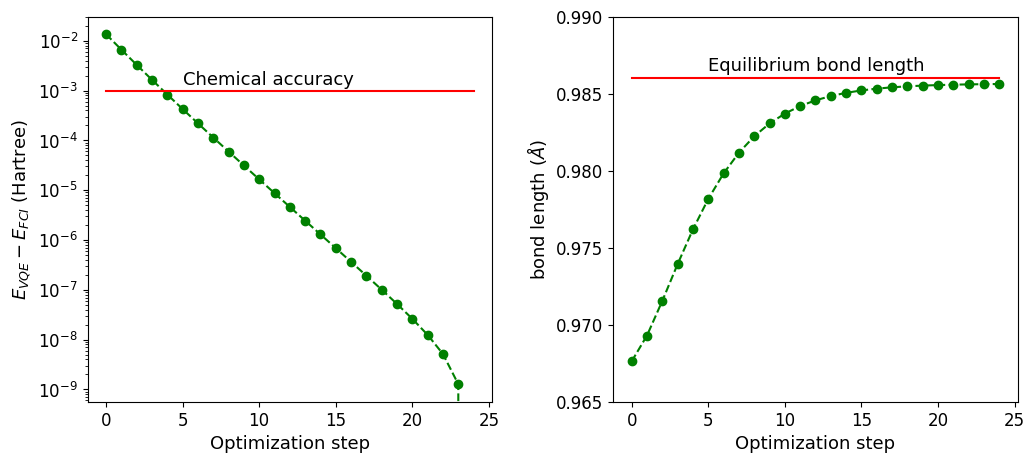

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Add energy plot on column 1
E_fci = -1.27443765658
E_vqe = np.array(energy)
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 1), E_vqe - E_fci, "go-", ls="dashed")
ax1.plot(range(n + 1), np.full(n + 1, 0.001), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("$E_{VQE} - E_{FCI}$ (Hartree)", fontsize=13)
ax1.text(5, 0.0013, r"Chemical accuracy", fontsize=13)
plt.yscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add bond length plot on column 2
d_fci = 0.986
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 1), bond_length, "go-", ls="dashed")
ax2.plot(range(n + 1), np.full(n + 1, d_fci), color="red")
ax2.set_ylim([0.965, 0.99])
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("bond length ($\AA$)", fontsize=13)
ax2.text(5, 0.9865, r"Equilibrium bond length", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3)
plt.show()